In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
path = '../astrometry_solutions/Luminance/RV_UMa_2022_03_20.fits'
f = fits.open(path)
w = WCS(f[0].header)
sky = w.pixel_to_world(3779.145830844237, 3130.8188850391607)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.00567496, 54.18045604)>


In [2]:
import ccdproc as ccdp
data = f[0].data
f.close()

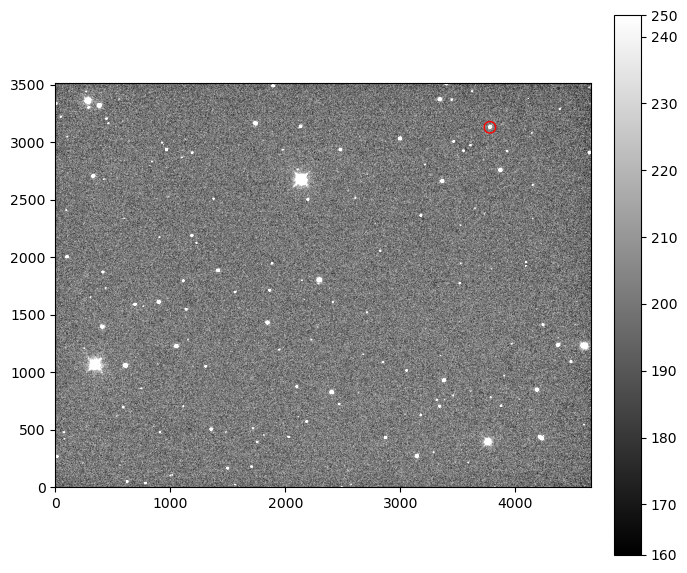

In [3]:
from convenience_functions import show_image
import matplotlib.pyplot as plt

show_image(data, cmap = 'gray')
circle = plt.Circle((3779.145830844237, 3130.8188850391607), 50, color = 'red', fill = False)
#plt.plot(3779.145830844237, 3130.8188850391607, marker = 'x', markersize = 5, color = 'red')
plt.gca().add_patch(circle);

# Finding the galaxy

In [4]:
path_22 = '../reduced-lights_2022_03_20/Luminance/RV_Uma_Light_Luminance_16_secs_001.fits'
data_22 = fits.open(path_22)[0].data

In [5]:
import pandas as pd
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

def find_sources(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)
    sources = daofind(array - median)
    return sources

def image_trimmer(sources, array):
    local_df = sources.to_pandas()
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    local_df = local_df[(local_df['xcentroid'] - x_trim > 0) & (local_df['xcentroid'] + x_trim < image_size[1])]
    local_df = local_df[(local_df['ycentroid'] - y_trim > 0) & (local_df['ycentroid'] + y_trim < image_size[0])]
    return local_df.reset_index(drop = True).drop('id', axis = 'columns')

def excluding_duplicates(df, fwhm):
    #Taking initial comparison values from first row
    xcenter, ycenter, flux = df.iloc[0][['xcentroid', 'ycentroid', 'flux']]
    last_index = 0
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if (xcenter - 3*fwhm <= row['xcentroid'] <= 3*fwhm + xcenter) or (ycenter - 3*fwhm <= row[
            'ycentroid'] <= 3*fwhm + ycenter):
            # Once we have the two that are very close to each other we want to keep the one with the highest flux
            if df.iloc[last_index]['flux'] > row['flux']:
                filters.append(False)
            else:
                filters[last_index] = False
                filters.append(True)
                xcenter = row['xcentroid']
                ycenter = row['ycentroid']
                last_index = index
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcentroid']
            ycenter = row['ycentroid']
            last_index = index
    result = df.loc[filters]
    return result.reset_index(drop=True)

def find_nearest(sources_1, sources_2):
    positions = np.transpose((sources_1['xcentroid'], sources_1['ycentroid']))
    positions_2 = np.transpose((sources_2['xcentroid'], sources_2['ycentroid']))
    mapping_dict = dict()
    for index, value in enumerate(positions):
        difference = np.subtract(positions_2, value)
        squared_difference = np.square(difference)
        min_index = np.sqrt(squared_difference.sum(axis = 1)).argmin()
        if index in mapping_dict:
            old_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][mapping_dict[index]])
            new_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][min_index])
            if old_difference_in_flux > new_difference_in_flux:
                mapping_dict[index] = min_index
        else:
            mapping_dict[index] = min_index
    for key, item in mapping_dict.items():
        x_1, y_1 = sources_1.iloc[key]['xcentroid'], sources_1.iloc[key]['ycentroid']
        x_2, y_2 = sources_2.iloc[item]['xcentroid'], sources_2.iloc[item]['ycentroid']
        distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
        if distance > 100:
            mapping_dict[key] = np.nan
    return mapping_dict

In [6]:
sources_22 = excluding_duplicates(image_trimmer(find_sources(data_22), data_22), 9)

In [13]:
sources_22

,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1706.077633,176.185848,0.661140,-0.173241,-0.312569,121,0.0,433.615254,2.224844,-0.868249
1,3587.861353,210.696653,0.649239,0.386934,0.343354,121,0.0,192.277376,1.248953,-0.241365
2,3142.474929,267.694491,0.287923,-0.028685,-0.268344,121,0.0,3641.860882,25.603635,-3.520754
3,4366.093378,319.673973,0.676847,-0.848360,-0.378170,121,0.0,109.603354,1.027018,-0.028946
4,796.115872,354.833570,0.901208,0.234516,0.249475,121,0.0,144.879759,1.037795,-0.040279
5,3760.950043,390.792943,0.458177,0.143955,0.075550,121,0.0,55300.251100,320.824266,-6.265668
6,4228.218530,421.410078,0.561852,0.167301,0.075003,121,0.0,6108.989988,33.206509,-3.803058
7,1356.464049,501.824838,0.633012,0.014017,-0.501354,121,0.0,1516.403587,6.994684,-2.111920
8,3176.503748,624.160576,0.714058,-0.094097,-0.149248,121,0.0,417.728232,2.033478,-0.770599
9,3340.636114,700.553976,0.319667,0.012596,-0.164676,121,0.0,675.328932,4.588116,-1.654086


In [15]:
for index, x, y in zip(sources_22.index, sources_22['xcentroid'], sources_22['ycentroid']):
    print(index, w.pixel_to_world(x, y))

0 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.70168591, 53.91601353)>
1 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.67943402, 54.16928149)>
2 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.66961172, 54.1090859)>
3 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.64870183, 54.273464)>
4 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.66821941, 53.79247604)>
5 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.63668126, 54.19175797)>
6 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.62621466, 54.2544677)>
7 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.62996607, 53.86737583)>
8 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.58737158, 54.1120353)>
9 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.5685329, 54.13377418)>
10 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.54783633, 54.00689274)>
11 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (203.53880383

# Reading the data

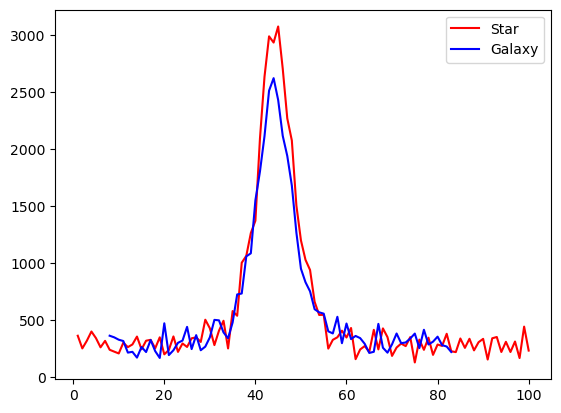

In [8]:


star_data = pd.read_csv('star.dat', sep = '\s+', names = ['index','value'], index_col='index')
galaxy_data = pd.read_csv('galaxy.dat', sep = '\s+', names = ['index','value'], index_col='index')
galaxy_x_axis = np.arange(8, 8+len(galaxy_data), 1)

plt.plot(star_data, color = 'red', label = 'Star')
plt.plot(galaxy_x_axis, galaxy_data, color = 'blue', label = 'Galaxy')
plt.legend()